In [2]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role
%matplotlib inline

# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()
print('bucket: {}'.format(bucket))

bucket: sagemaker-us-east-1-359836831178


In [3]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path and hyperparamenters
output_path = 's3://{}/{}'.format(bucket, 'Deblurring')

hyperparameters={
        'epochs':3000,
        'lr':2e-4,
        'batch-size': 1
    }

# instantiate a pytorch estimator
estimator = PyTorch(
    'train.py',
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=output_path,
    framework_version='1.0',
    py_version='py3',
    source_dir='source',
    hyperparameters=hyperparameters
)

## Train the Estimator

After instantiating the estimator, we train it with a call to `.fit()`.

In [ ]:
%%time
# train the estimator on S3 training data
train_data='s3://{}/Deblurring/Datasets/GoPro/train'.format(bucket)
test_data='s3://{}/Deblurring/Datasets/GoPro/test'.format(bucket)
estimator.fit({'train': train_data, 
              'test': test_data})

Note: the ml.p3.2xlarge does not have enough memory even for batch-size of 4. Training the required 3000 epochs would take too long, so I will be using a pre-trained model, but my code works for whoever wants to train the model. It will likely require a larger, more expansive, EC2 instance.

In [12]:
# create and deploy a model to deblur video
import os
from sagemaker.pytorch import PyTorchModel
model_dir = os.path.join('Deblurring','Model')
model_data= 's3://{}/{}/model.tar.gz'.format(bucket,model_dir)
# Create a model from the trained estimator data
# And point to the prediction script
env = {'SAGEMAKER_MODEL_SERVER_TIMEOUT' : '300' }
model = PyTorchModel(
    model_data=model_data,
    role=role,
    framework_version='1.8',
    py_version='py3',
    entry_point='predict.py',
    source_dir='source',
    env=env
)

print(model_data)

s3://sagemaker-us-east-1-359836831178/Deblurring/Model/model.tar.gz


In [13]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.p3.2xlarge')

---------------------!CPU times: user 6.99 s, sys: 1.01 s, total: 8 s
Wall time: 10min 40s


Load a blurred image and make a restoration using the model

<class 'numpy.ndarray'>


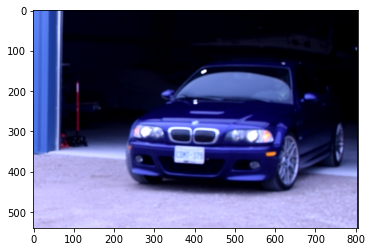

In [23]:
# download the sample image from s3

sample_dir='sample'
os.makedirs(sample_dir, exist_ok=True)
local_file_path = os.path.join(sample_dir,'blur.png')

# download from s3...
s3 = boto3.client('s3')
with open(local_file_path, 'wb') as f:
    s3.download_fileobj(bucket, os.path.join('Deblurring', 'Sample', 'blur.png'), f)

from PIL import Image
img = Image.open(local_file_path).convert('RGB')

# display the blurred image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plt.imshow(img)
img_asarr = np.array(img)
print(type(img_asarr))

In [25]:
# test the deployed model on the blurred image
predictor.predict(img_asarr)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2021-05-29-15-55-53-356 in account 359836831178 for more information.